In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env IGS_FASTMRI_S=1
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import torch
from optimize_pattern import get_dataset, get_segmentation_model, PatternSampler, COIL_MAP, refine_data_batch
from k_space_reconstruction.nets.cdn import UnetDCCascade
from train_unet import Unet
from k_space_reconstruction.utils.kspace import RandomMaskFunc
from kspace import pt_kspace2spatial as IFt
from kspace import pt_spatial2kspace as Ft
from networks import UnetCS, CascadeCS

def fake_batch(data):
    return {k:v[None] if v is not None else None for k,v in data.items()}

env: CUDA_VISIBLE_DEVICES=0
env: IGS_FASTMRI_S=1


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
k_sampler = PatternSampler(f_maps=None, shape=[320, 320], device=device)
_, val_dataset = get_dataset(name='fastmri_plus', volumetric=False, device=device)

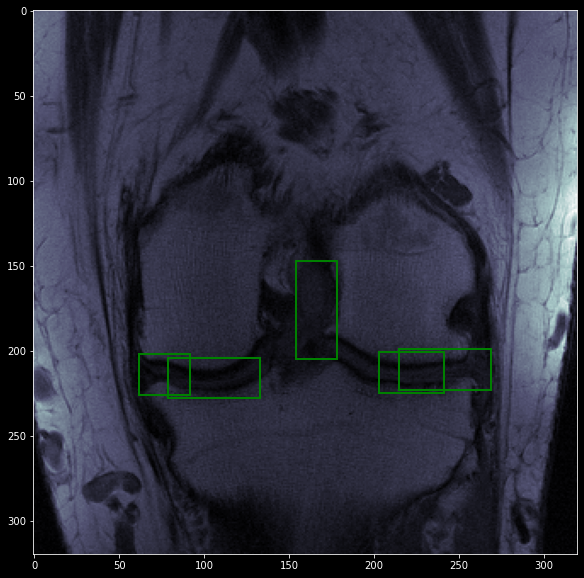

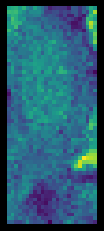

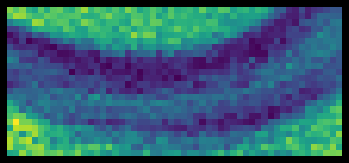

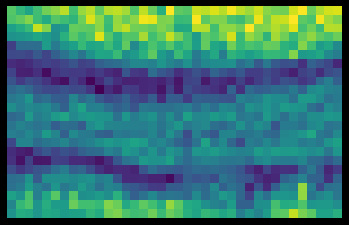

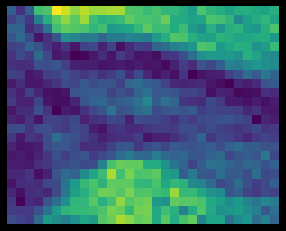

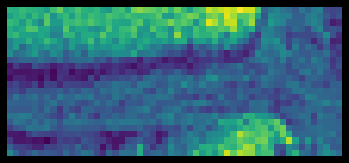

In [3]:
data = val_dataset[29]
plt.figure(figsize=(10,10))
plt.imshow(data['img'][0].cpu(), cmap=plt.cm.bone)
for box in data['boxes']:
    patch = plt.matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=2, edgecolor='green', facecolor='none')
    plt.gca().add_patch(patch)
plt.show()
for (y0, x0, y1, x1) in data['boxes']:
    plt.imshow(data['img'][0].cpu()[x0:x1,y0:y1])
    plt.axis('off')
    plt.show()

In [4]:
cascade_plus = CascadeCS(16, 4).cuda().eval()
cascade_plus.net.load_state_dict(torch.load('logs/pattern/fastmri_plus/cs-cascade/loupe/x4_singlecoil_1d_plus-ssim-l1/v1/model_state.pt'))
cascade = CascadeCS(16, 4).cuda().eval()
cascade.net.load_state_dict(torch.load('logs/pattern/fastmri_plus/cs-cascade/loupe/x4_singlecoil_1d_ssim-l1/v1/model_state.pt'))

p_plus = torch.load('logs/pattern/fastmri_plus/cs-cascade/loupe/x4_singlecoil_1d_plus-ssim-l1/v1/pattern.pt')
p = torch.load('logs/pattern/fastmri_plus/cs-cascade/loupe/x4_singlecoil_1d_ssim-l1/v1/pattern.pt')

In [5]:
from tqdm import tqdm
from optimize_pattern import pt_ssim
from collections import defaultdict

val_generator = torch.utils.data.DataLoader(
    val_dataset,
    collate_fn=lambda batch: [{k:v for k,v in b.items()} for b in batch],
    batch_size=1, shuffle=False
)

ssim_metrics = defaultdict(list)
with torch.no_grad():
    for data in tqdm(val_generator):
        data = refine_data_batch(data)
        data['sampling'] = p_plus
        x = refine_data_batch(data)
        y = k_sampler(x, sampling=p_plus)
        res = cascade_plus(y)
        ssim_metrics['ssim'].append(pt_ssim(res, x['img']).item())
        bboxes = x['boxes']
        val = 0
        count = 0
        for i, boxes in enumerate(bboxes):
            for (y0, x0, y1, x1) in boxes:
                val += pt_ssim(res[i,:,x0:x1,y0:y1][None], x['img'][i,:,x0:x1,y0:y1][None])
                count += 1
        ssim_metrics['ssim+'].append((val / count).item())
print(np.mean(ssim_metrics['ssim']), np.mean(ssim_metrics['ssim+']))

100%|██████████| 338/338 [00:17<00:00, 18.96it/s]

0.8007556919515486 0.7861314444146918


In [6]:
from tqdm import tqdm
from optimize_pattern import pt_ssim
from collections import defaultdict

val_generator = torch.utils.data.DataLoader(
    val_dataset,
    collate_fn=lambda batch: [{k:v for k,v in b.items()} for b in batch],
    batch_size=1, shuffle=False
)

ssim_metrics = defaultdict(list)
with torch.no_grad():
    for data in tqdm(val_generator):
        data = refine_data_batch(data)
        data['sampling'] = p
        x = refine_data_batch(data)
        y = k_sampler(x, sampling=p)
        res = cascade(y)
        ssim_metrics['ssim'].append(pt_ssim(res, x['img']).item())
        bboxes = x['boxes']
        val = 0
        count = 0
        for i, boxes in enumerate(bboxes):
            for (y0, x0, y1, x1) in boxes:
                val += pt_ssim(res[i,:,x0:x1,y0:y1][None], x['img'][i,:,x0:x1,y0:y1][None])
                count += 1
        ssim_metrics['ssim+'].append((val / count).item())
print(np.mean(ssim_metrics['ssim']), np.mean(ssim_metrics['ssim+']))

100%|██████████| 338/338 [00:17<00:00, 19.31it/s]

0.843972400448026 0.7920948917696462


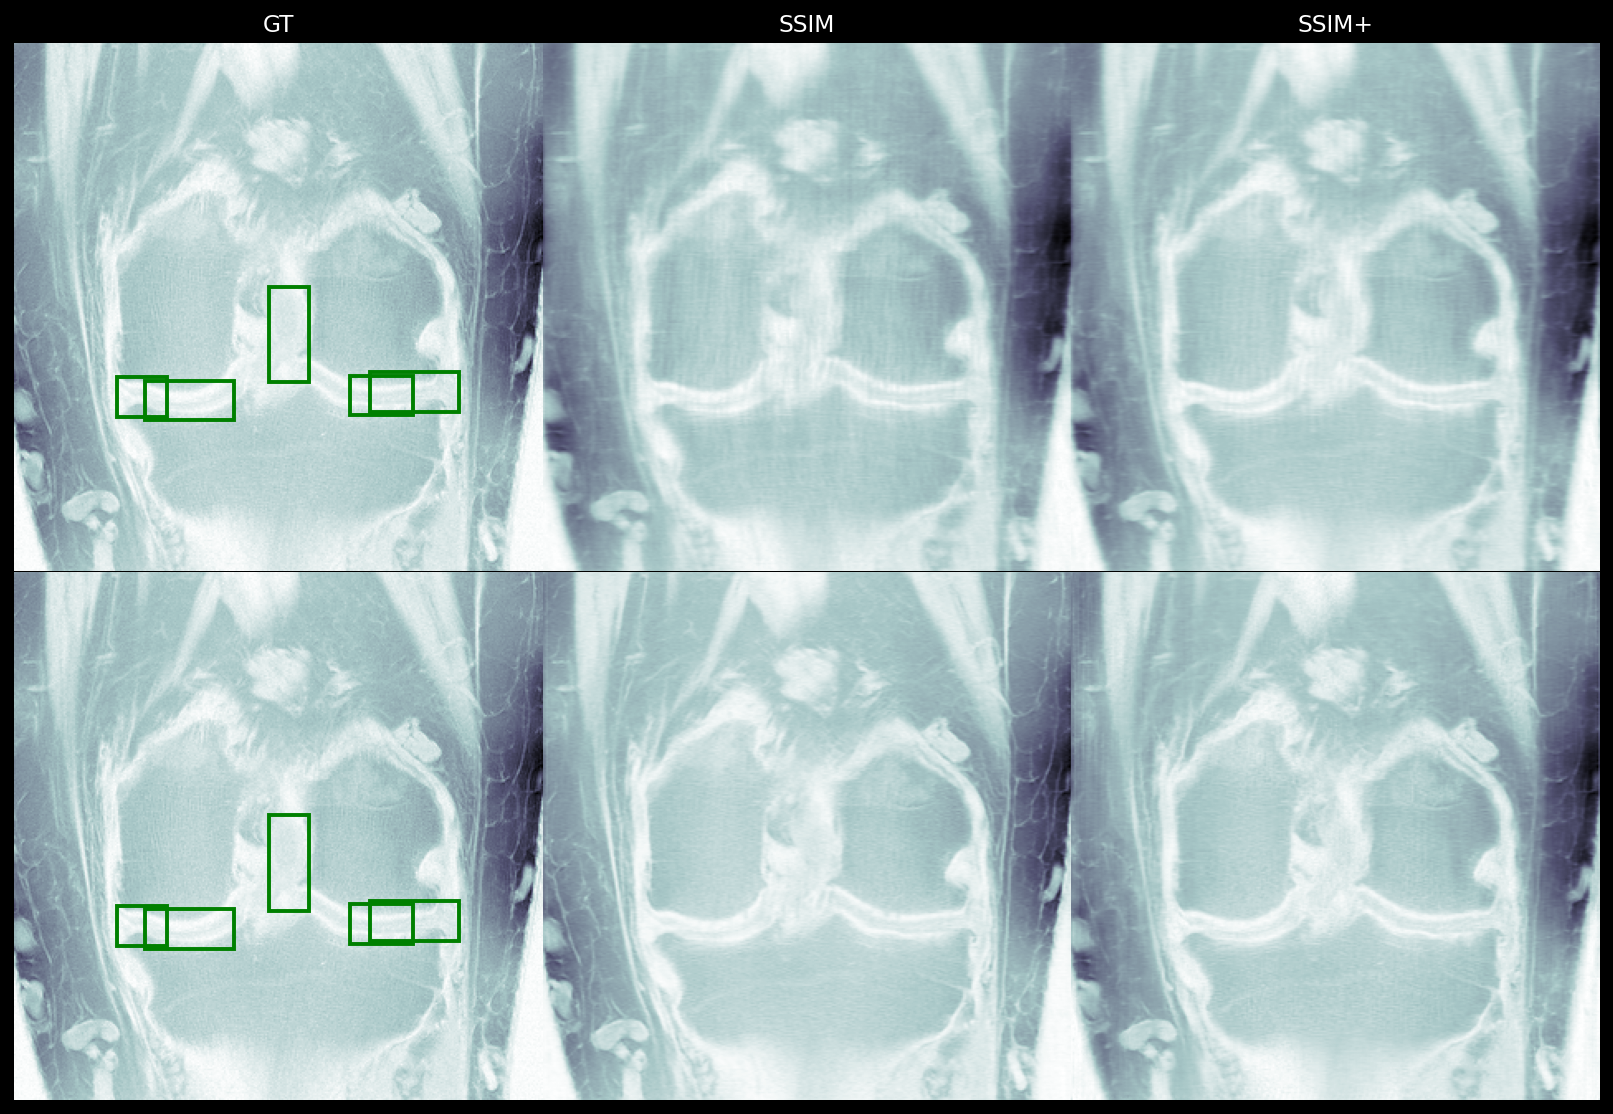

/home/a_razumov/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


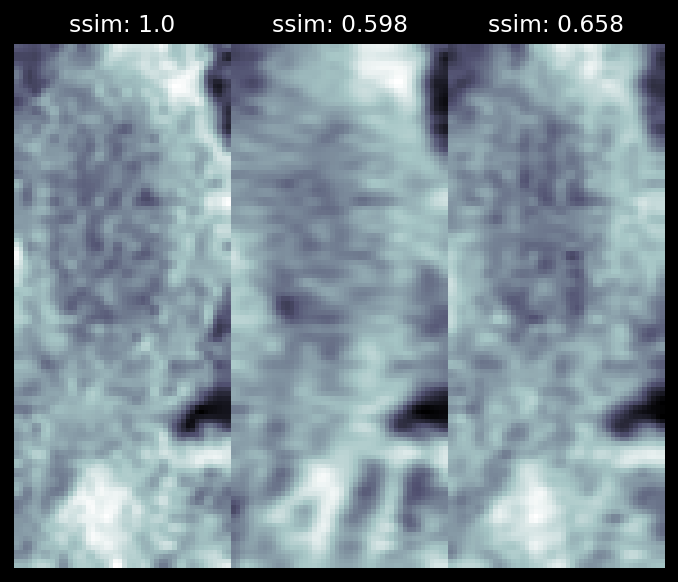

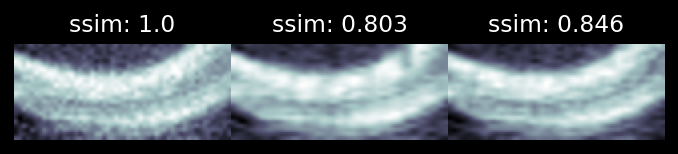

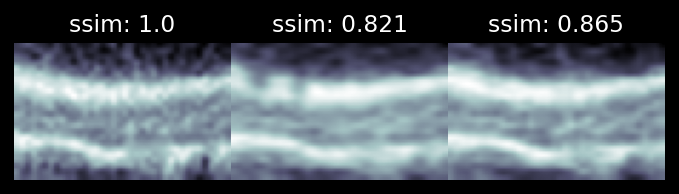

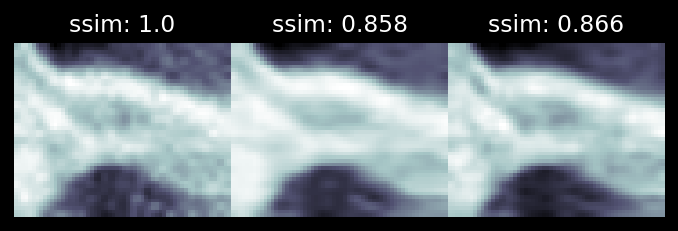

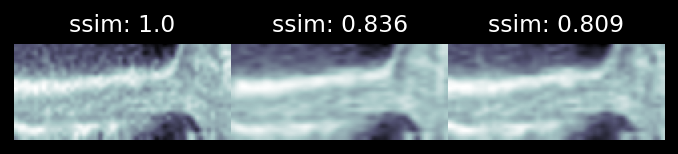

In [16]:
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable

data = val_dataset[29]
data1 = refine_data_batch([{k:v for k,v in b.items()} for b in [data]])
data1['sampling'] = p
data2 = refine_data_batch([{k:v for k,v in b.items()} for b in [data]])
data2['sampling'] = p_plus
dd1 = k_sampler(data1, sampling=p)
dd2 = k_sampler(data2, sampling=p_plus)
with torch.no_grad():
    res1 = cascade(dd1).cpu().detach()
    res2 = cascade_plus(dd2).cpu().detach()

fig = plt.figure(figsize=(20, 10), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,3), axes_pad=0.0)
images = [data1['img'], dd1['img'], dd2['img'], data1['img'], res1, res2]
images = [v[0,0].cpu().detach() for v in images]
c = 0
for ax, im in zip(grid, images):
    if c in [0,3]:
        if c == 0:
            ax.set_title('GT')
        for box in data1['boxes'][0]:
            patch = plt.matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                             linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(patch)
    elif c == 1:
        ax.set_title('SSIM')
    elif c == 2:
        ax.set_title('SSIM+')
    ax.imshow(im, cmap=plt.cm.bone_r)
    ax.axis('off')
    c += 1
plt.show()

for (y0, x0, y1, x1) in data['boxes']:
    fig = plt.figure(figsize=(6, 6), dpi=140)
    grid = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad=0.0)
    images = [data1['img'], res1, res2]
    for ax, im in zip(grid, images):
        pred = im[0,0].cpu().detach()[x0:x1,y0:y1][None, None]
        t = data1['img'][0,0].cpu().detach()[x0:x1,y0:y1][None, None]
        pred = F.interpolate(pred, scale_factor=2, mode='bilinear')
        t = F.interpolate(t, scale_factor=2, mode='bilinear')
        ax.imshow(pred[0,0], cmap=plt.cm.bone_r)
        ax.set_title(f'ssim: {round(pt_ssim(pred, t).item(), 3)}')
        ax.axis('off')
    plt.show()